In [60]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
%matplotlib inline
plt.style.use('seaborn-v0_8')

# Знакомство с данными

In [61]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

* age — возраст страхователя;
* sex — пол;
* bmi — индекс массы тела (кг/м^2), в идеале — от 18.5 до 24.9;
* children — количество детей, охваченных медицинской страховкой;
* smoker — является ли человек курящим;
* region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
* charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

Размер таблицы:

In [62]:
print(data.shape)

(1338, 7)


Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

In [63]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

Посмотрим на типы данных:

In [64]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

* age, bmi, children — числовые признаки;
* sex, smoker — бинарные категориальные переменные (две категории);
* region — множественные категориальные переменные (несколько категорий);
* charges — числовой целевой признак.

# Исследование
Прежде чем приступать к этапу подготовки данных для модели, вы можете произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

гистограммы/коробчатые диаграммы числовых признаков;

столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;

диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных (обратите особенное внимание на зависимость медицинских расходов от признака курения).

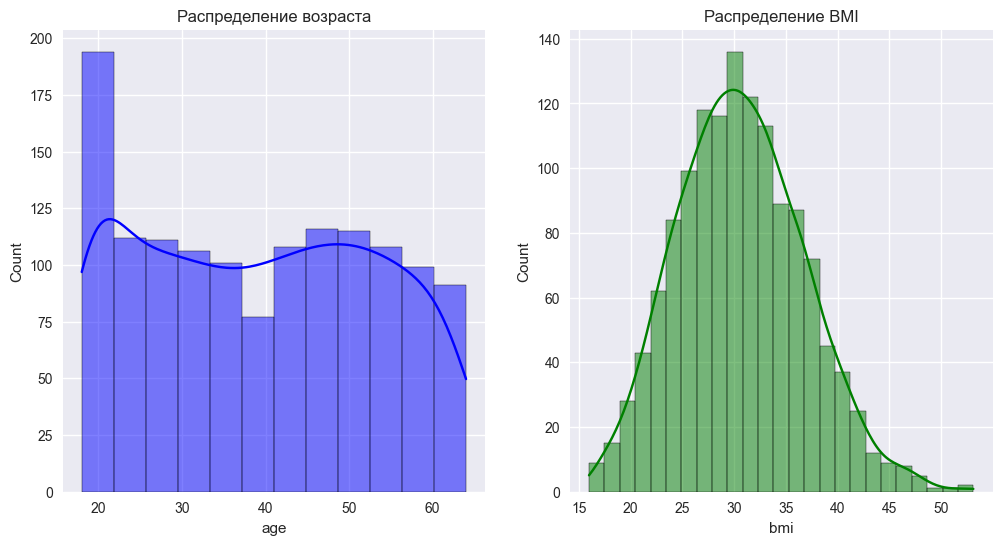

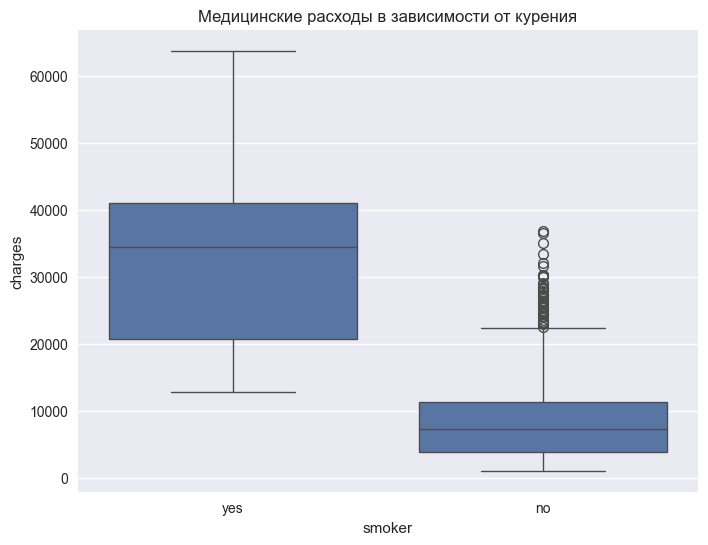

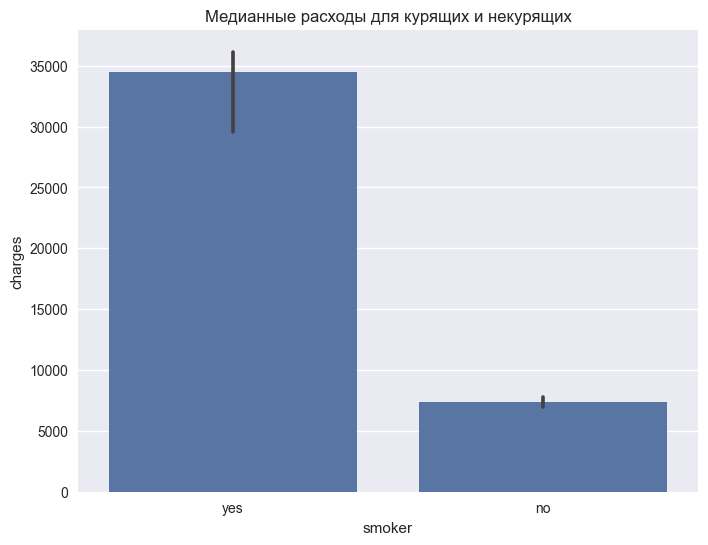

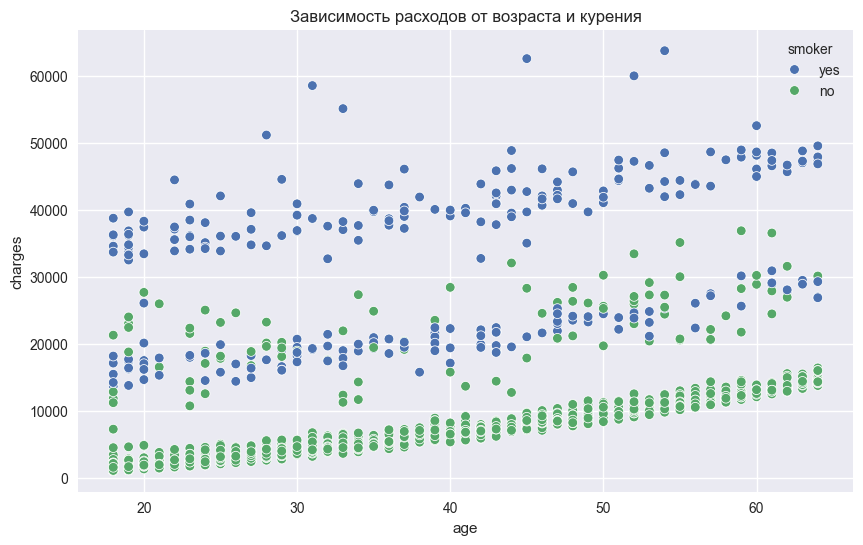

In [65]:
# Гистограммы числовых признаков
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['age'], kde=True, color='blue')
plt.title('Распределение возраста')

plt.subplot(1, 2, 2)
sns.histplot(data['bmi'], kde=True, color='green')
plt.title('Распределение BMI')
plt.show()

# Коробчатые диаграммы
plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='charges', data=data)
plt.title('Медицинские расходы в зависимости от курения')
plt.show()

# Столбчатые диаграммы медианных расходов
plt.figure(figsize=(8, 6))
sns.barplot(x='smoker', y='charges', data=data, estimator='median')
plt.title('Медианные расходы для курящих и некурящих')
plt.show()

# Диаграммы рассеяния
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', hue='smoker', data=data)
plt.title('Зависимость расходов от возраста и курения')
plt.show()

Распределение данных: Есть ли выбросы, асимметрия или другие особенности.

Влияние категориальных признаков: Например, курящие могут иметь значительно более высокие медицинские расходы.

Зависимости между признаками: Например, с увеличением возраста или BMI могут расти медицинские расходы.

# Кодирование признаков

Кодировку будем совершать по следующему принципу:

* smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
* sex — аналогично (0 — female, 1 — male);
* region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [66]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)

# Преобразуем логические значения в числовые (0 и 1)
data[['region_northeast','region_northwest', 'region_southeast', 'region_southwest']] = data[['region_northeast','region_northwest', 'region_southeast', 'region_southwest']].astype(int)

data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Итак, мы получили перекодированную таблицу, в которой все признаки являются числовыми.

Выделим факторы и целевой признак в отдельные таблицы:

In [67]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

Задание 6.1

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.

В качестве значения параметра random_state укажите число 42.

Чему равно количество наблюдений в тестовом наборе данных?

In [68]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


Задание 6.2

Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию.

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [69]:
# Создаём объект класса LinearRegression
lr_model = linear_model.LinearRegression()

# Обучаем модель — ищем параметры по МНК
lr_model.fit(X_train, y_train)

# Получаем свободный член (intercept) и округляем его до сотых
print('w0: {:.2f}'.format(lr_model.intercept_))  # свободный член w0, округлённый до сотых

y_train_predict = lr_model.predict(X_train)
y_test_predict = lr_model.predict(X_test)

w0: -12390.80


Задание 6.3

С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики: R^2, MAE, MAE. Не забудьте привести значение MAPE к процентам.

Значение R^2 округлите до трёх знаков после точки-разделителя, а значения MAE и MAPE — до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [70]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [71]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42


Test R^2: 0.784
Test MAE: 4181
Test MAPE: 47


Задание 6.4

Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: y-y^ (без модуля).

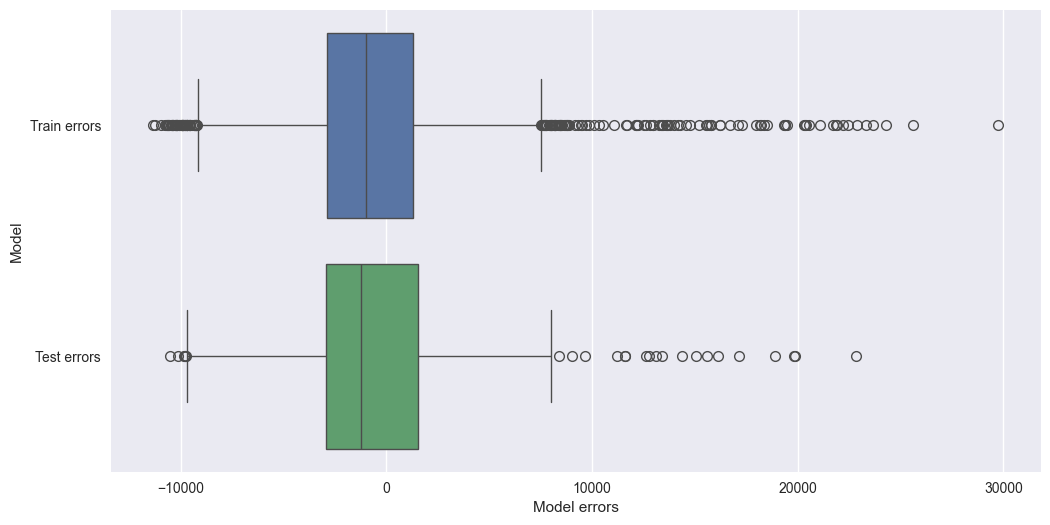

In [72]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - lr_model.predict(X_train)
#Ошибки модели на тестовой выборке
y_test_errors = y_test - lr_model.predict(X_test)
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Разброс ошибок на тренировочной выборке больше, чем на тестовой.

Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0).

Задание 6.5

Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.

Примечание. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом PolynomialFeatures из библиотеки sklearn. Значение параметра include_bias выставите на False.

In [73]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)

(1070, 54)


c:\phython\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\phython\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Задание 6.6

Обучите модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики R^2 на тестовой выборке?

Значение R^2 округлите до трёх знаков после запятой.

In [74]:
#Создаём объект класса LinearRegression
lr_poly = linear_model.LinearRegression()
#Обучаем модель по МНК
lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict = lr_poly.predict(X_test_scaled_poly)
 
#Рассчитываем коэффициент детерминации для двух выборок
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE: 2912
Train MAPE: 29


Test R^2: 0.866
Test MAE: 2756
Test MAPE: 30


Задание 6.7

Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

Какой вывод можно сделать?

In [75]:
print(lr_model.coef_)

[ 2.56975706e+02 -1.85916916e+01  3.37092552e+02  4.25278784e+02
  2.36511289e+04  4.59585244e+02  8.89079180e+01 -1.98279052e+02
 -3.50214110e+02]


Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.

Задание 6.8

Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики R^2, MAE и MAPE на тестовой выборке?

Значение R^2 округлите до трёх знаков после запятой, а значения MAE и MAPE до целого числа.

In [76]:
lasso_lr_poly = linear_model.Lasso()
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_predict = lasso_lr_poly.predict(X_test_scaled_poly)

# print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
# print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
# print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
# print('\n')
# print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
# print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
# print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

c:\phython\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.292e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(


Train R^2: 0.842
Train MAE: 2889
Train MAPE: 29


Test R^2: 0.867
Test MAE: 2718
Test MAPE: 30


In [77]:
ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predict = ridge_lr_poly.predict(X_test_scaled_poly)

# print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
# print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
# print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
# print('\n')
# print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
# print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
# print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30


Test R^2: 0.863
Test MAE: 2861
Test MAPE: 31
